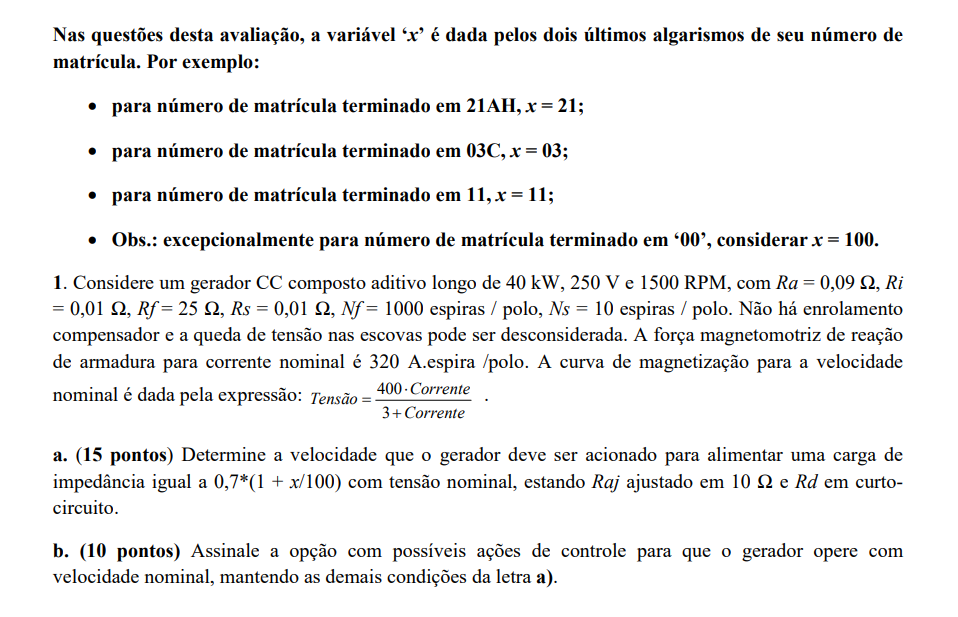

In [15]:
#QUESTAO 1

from scipy.optimize import fsolve

# Entrada do usuário: valor x
x = int(input("Digite o valor de x (ex: 21): "))
if x == 0:
    x = 100

# Dados nominais
Potencia_nominal = 40000  # W
Tensao_nominal = 250      # V
Velocidade_nominal = 1500 # rpm

# Parâmetros elétricos
Ra = 0.09
Ri = 0.01
Rf = 25
Rs = 0.01
Raj = 10  # dado da questão 1
Rd = 0    # curto circuito

Nf = 1000
Ns = 10

# Impedância da carga
Z_load = 0.7 * (1 + x/100)

# Função da curva de magnetização: V = 400*I^3 + I
# Aqui precisamos inverter para achar I_f a partir da tensão do campo V_f.
# Vamos usar método numérico para achar I_f dado V_f.
def corrente_campo(Vf):
    # Função para achar corrente If para um dado Vf (Rf + Raj)
    def f_I(I):
        return 400*I**3 + I - Vf
    If_initial_guess = Vf / Rf
    If_solution = fsolve(f_I, If_initial_guess)[0]
    return If_solution

# Função para achar velocidade n que satisfaça a tensão nominal no gerador
def func_velocidade(n):
    # Corrente de armadura (carga)
    Ia = Tensao_nominal / Z_load  # Corrente na carga

    # Corrente de campo shunt
    Vf = Tensao_nominal  # Tensão no ramo do campo (aprox)
    If = corrente_campo(Vf)  # corrente no campo shunt pela curva inversa

    # Corrente de série (como Rd=0, corrente de série = Ia)
    Is = Ia

    # FMM reação armadura para corrente nominal:
    Ia_nominal = Potencia_nominal / Tensao_nominal
    K_reacao = 320 / Ia_nominal

    # FMM total (considerando reação)
    FMM_total = Nf*If + Ns*Is - K_reacao*Ia

    # Tensão induzida proporcional a velocidade e FMM_total
    # Assumindo proporcionalidade:
    Ea = n / Velocidade_nominal * (Tensao_nominal / (Nf*(Potencia_nominal/Tensao_nominal/Rf) + Ns*(Potencia_nominal/Tensao_nominal) - K_reacao*(Potencia_nominal/Tensao_nominal))) * FMM_total

    # Quedas resistivas (aprox)
    V_drop = Ia*Ra + Ia*Ri + Is*Rs

    Vt_calc = Ea - V_drop

    # Queremos que Vt_calc seja igual a Tensao_nominal
    return Vt_calc - Tensao_nominal

# Resolver para n
n_initial_guess = Velocidade_nominal
n_sol = fsolve(func_velocidade, n_initial_guess)[0]

print(f"\nResultado Questão 1a:")
print(f"Para x = {x}, a velocidade para alimentar a carga com tensão nominal é aproximadamente: {n_sol:.2f} rpm")
print(f"Impedância da carga usada: {Z_load:.4f} Ω")

# --- Letra b ---

print("\nQuestão 1b: Possíveis ações de controle para manter velocidade nominal:")

print("""
- Ajustar a resistência de campo shunt (Raj) para controlar a corrente de campo e, consequentemente, o fluxo magnético.
- Alterar a tensão de excitação para compensar variações na carga e manter a tensão constante.
- Utilizar sistemas automáticos de regulação de tensão que ajustem a corrente de campo conforme a velocidade.
""")


Digite o valor de x (ex: 21): 100

Resultado Questão 1a:
Para x = 100, a velocidade para alimentar a carga com tensão nominal é aproximadamente: 5443.45 rpm
Impedância da carga usada: 1.4000 Ω

Questão 1b: Possíveis ações de controle para manter velocidade nominal:

- Ajustar a resistência de campo shunt (Raj) para controlar a corrente de campo e, consequentemente, o fluxo magnético.
- Alterar a tensão de excitação para compensar variações na carga e manter a tensão constante.
- Utilizar sistemas automáticos de regulação de tensão que ajustem a corrente de campo conforme a velocidade.



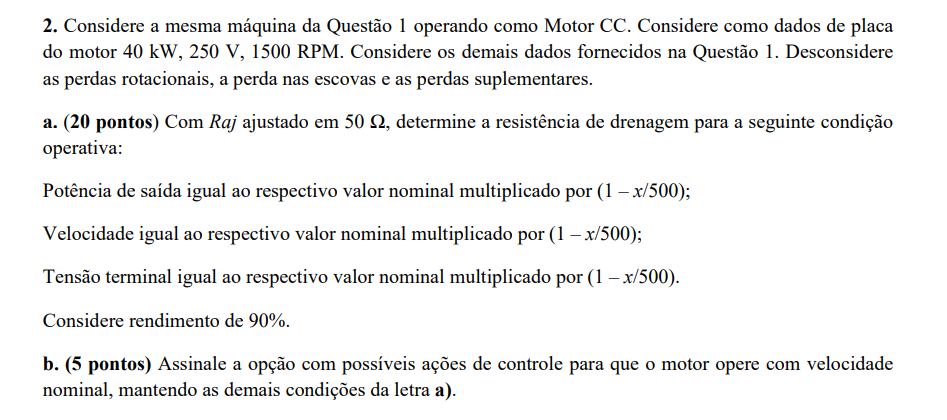

In [14]:
from scipy.optimize import fsolve

# 📥 Interação com o usuário
x = int(input("Digite o valor de x (ex: 100): "))

# Dados nominais
Potencia_nominal = 40000
Tensao_nominal = 250
Velocidade_nominal = 1500

# Parâmetros do motor
Ra = 0.09
Ri = 0.01
Rf = 25
Rs = 0.01
Nf = 1000
Ns = 10
Raj = 50
n = 0.9

# Corrente nominal de armadura aproximada (entrada/rendimento / tensão nominal)
Ia_nominal = (Potencia_nominal / n) / Tensao_nominal  # Ex: ~177.78 A

# Constante reação armadura: 320 A.espira/polo para Ia nominal
K_reacao = 320 / Ia_nominal  # A.espira/polo por ampere

# Fator de redução
f = 1 - x / 500

# Cálculos principais
Potencia_saida = Potencia_nominal * f
Velocidade = Velocidade_nominal * f
Tensao_terminal = Tensao_nominal * f
Potencia_entrada = Potencia_saida / n
Ia = Potencia_entrada / Tensao_terminal
If = Tensao_terminal / Rf
IL = Ia - If

# Função para resolver numericamente Rd, agora considerando reação de armadura
def objetivo(Rd_array):
    Rd = float(Rd_array[0])
    Is = IL * (Rd / (Rs + Rd))
    Id = IL * (Rs / (Rs + Rd))

    # FMM total considerando reação de armadura (oposta)
    FMM_total = Nf * If + Ns * Is - K_reacao * Ia

    # Assumindo proporcionalidade Ea ~ FMM_total (ou fluxo ~ FMM_total)
    # Podemos definir constante de proporcionalidade entre Ea e FMM_total com base no nominal:
    # No nominal: Ea_nominal ~ Tensao_nominal + perdas (para simplicidade, usa Tensao_nominal)
    # Então: constante = Tensao_nominal / (Nf * If_nominal + Ns * Is_nominal - K_reacao * Ia_nominal)
    # Mas como Is depende de Rd que queremos achar, simplificamos adotando constante = Tensao_nominal / FMM_nominal

    # Estimando FMM nominal (corrente nominal):
    If_nominal = Tensao_nominal / Rf
    IL_nominal = Ia_nominal - If_nominal
    # Suposição: sem resistor de drenagem nominal (Rd ~ 0.5 para iniciar)
    Rd_teste = 0.5
    Is_nominal = IL_nominal * (Rd_teste / (Rs + Rd_teste))
    FMM_nominal = Nf * If_nominal + Ns * Is_nominal - K_reacao * Ia_nominal

    k_Ea_FMM = Tensao_nominal / FMM_nominal  # constante de proporcionalidade

    Ea_calc = k_Ea_FMM * FMM_total

    # Adiciona quedas resistivas (modelagem detalhada)
    Ea_calc += Ia * Ra + IL * Ri + Is * Rs + Id * Rd

    Ea_esperado = Tensao_nominal * f

    return Ea_calc - Ea_esperado

# Resolver numericamente
Rdinicial = [0.5]
Rsol = fsolve(objetivo, Rdinicial)
Rd_final = float(Rsol[0])

# Cálculo final com Rd encontrado
Is = IL * (Rd_final / (Rs + Rd_final))
Id = IL * (Rs / (Rs + Rd_final))
FMM_total = Nf * If + Ns * Is - K_reacao * Ia
k_Ea_FMM = Tensao_nominal / (Nf * (Tensao_nominal / Rf) + Ns * (IL * (Rd_final / (Rs + Rd_final))) - K_reacao * Ia_nominal)
Ea_final = k_Ea_FMM * FMM_total + Ia*Ra + IL*Ri + Is*Rs + Id*Rd_final
Ea_esperado = Tensao_nominal * f

# 📘 Explicação passo a passo
print("\n📘 Explicação passo a passo:")

print(f"\n1️⃣ Como o motor está operando com:")
print(f"- Potência ajustada:  {Potencia_nominal} × {f:.2f} = {Potencia_saida:.2f} W")
print(f"- Velocidade ajustada: {Velocidade_nominal} × {f:.2f} = {Velocidade:.2f} rpm")
print(f"- Tensão ajustada:    {Tensao_nominal} × {f:.2f} = {Tensao_terminal:.2f} V")
print(f"- Rendimento: {n*100:.0f}%")

print(f"\n➡️ Corrente na armadura:")
print(f"Ia = Pot_entrada / Vt = {Potencia_entrada:.2f} / {Tensao_terminal:.2f} = {Ia:.2f} A")

print(f"\n➡️ Corrente no campo shunt:")
print(f"If = Vt / Rf = {Tensao_terminal:.2f} / {Rf} = {If:.2f} A")

print(f"\n➡️ Corrente na carga (IL):")
print(f"IL = Ia - If = {Ia:.2f} - {If:.2f} = {IL:.2f} A")

print(f"\n2️⃣ A corrente IL se divide entre:")
print(f"Is = IL × (Rd / (Rs + Rd)) = {IL:.2f} × ({Rd_final:.4f} / ({Rs} + {Rd_final:.4f})) = {Is:.2f} A")
print(f"Id = IL × (Rs / (Rs + Rd)) = {IL:.2f} × ({Rs} / ({Rs} + {Rd_final:.4f})) = {Id:.2f} A")

print(f"\n3️⃣ A força magnetomotriz total (FMM) considerando reação da armadura:")
print(f"FMM = Nf×If + Ns×Is - K_reacao×Ia = {Nf}×{If:.2f} + {Ns}×{Is:.2f} - {K_reacao:.3f}×{Ia:.2f} = {FMM_total:.2f} A.espira")

print(f"\n4️⃣ A tensão induzida Ea considerando perdas e fluxo reduzido:")
print(f"Ea = k_Ea_FMM×FMM + Ia×Ra + IL×Ri + Is×Rs + Id×Rd = {Ea_final:.2f} V")

print(f"\n5️⃣ A tensão esperada com rotação reduzida:")
print(f"Ea_esperada = {Tensao_nominal} × {f:.2f} = {Ea_esperado:.2f} V")

# Resultado final
if Rd_final < 0:
    print(f"\n❌ Resultado: R_d = {Rd_final:.4f} Ω (valor não físico, não é necessário resistor de drenagem nesta condição).")
else:
    print(f"\n✅ Resultado: R_d = {Rd_final:.4f} Ω é a resistência de drenagem correta.")

# 🔍 Comentário explicativo final
print("\n💡 Nota:")
print("Agora a reação da armadura foi considerada na FMM, ajustando o fluxo e a tensão induzida.")
print("A resistência de drenagem foi calculada numericamente para equilibrar a tensão terminal esperada.")

# Letra B
print("\n📌 Questão 2 - Letra (b): Ações de controle para operar com velocidade nominal:")

print("\n👉 Como a rotação aumentaria de 1200 rpm para 1500 rpm, para manter a tensão terminal e potência iguais,")
print("é necessário reduzir o fluxo magnético do motor.")

print("✅ Uma ação de controle possível é AUMENTAR a resistência no campo shunt (Raj),")
print("diminuindo a corrente If e o fluxo. Isso compensa o aumento de rotação e mantém a tensão induzida constante.")


Digite o valor de x (ex: 100): 100

📘 Explicação passo a passo:

1️⃣ Como o motor está operando com:
- Potência ajustada:  40000 × 0.80 = 32000.00 W
- Velocidade ajustada: 1500 × 0.80 = 1200.00 rpm
- Tensão ajustada:    250 × 0.80 = 200.00 V
- Rendimento: 90%

➡️ Corrente na armadura:
Ia = Pot_entrada / Vt = 35555.56 / 200.00 = 177.78 A

➡️ Corrente no campo shunt:
If = Vt / Rf = 200.00 / 25 = 8.00 A

➡️ Corrente na carga (IL):
IL = Ia - If = 177.78 - 8.00 = 169.78 A

2️⃣ A corrente IL se divide entre:
Is = IL × (Rd / (Rs + Rd)) = 169.78 × (0.0045 / (0.01 + 0.0045)) = 53.02 A
Id = IL × (Rs / (Rs + Rd)) = 169.78 × (0.01 / (0.01 + 0.0045)) = 116.76 A

3️⃣ A força magnetomotriz total (FMM) considerando reação da armadura:
FMM = Nf×If + Ns×Is - K_reacao×Ia = 1000×8.00 + 10×53.02 - 1.800×177.78 = 8210.17 A.espira

4️⃣ A tensão induzida Ea considerando perdas e fluxo reduzido:
Ea = k_Ea_FMM×FMM + Ia×Ra + IL×Ri + Is×Rs + Id×Rd = 219.79 V

5️⃣ A tensão esperada com rotação reduzida:
Ea_esperad

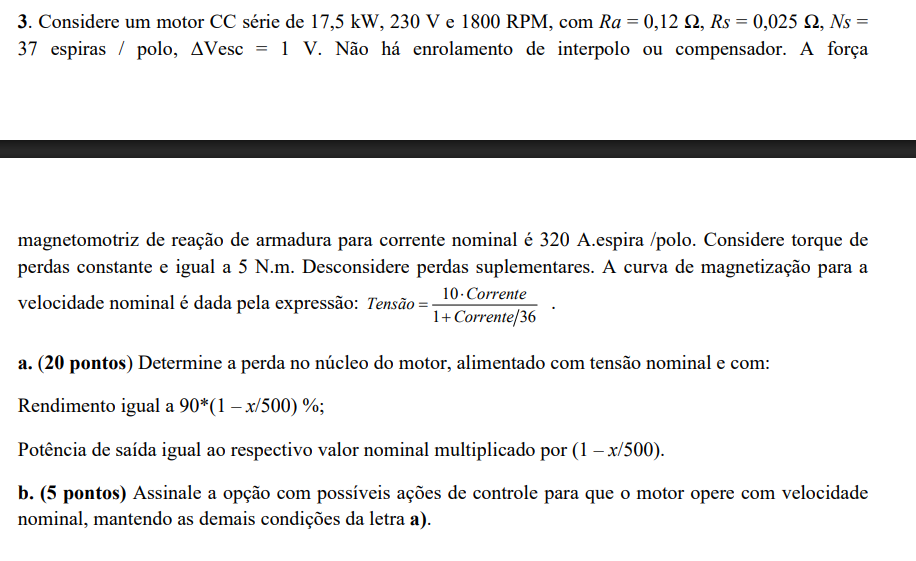

In [16]:
#QUESTAO 3

import math

# Entrada do usuário para x
x = int(input("Digite o valor de x (ex: 21): "))
if x == 0:
    x = 100

# Dados fornecidos
P_nominal = 17500       # W
V_tensao = 230          # V
n_nominal = 1800        # rpm
Ra = 0.12               # ohms
Rs = 0.025              # ohms
Delta_V_esc = 1         # V
T_perdas = 5            # Nm

# Cálculo do rendimento e potência de saída ajustados
fator = 1 - x/500
rendimento = 0.9 * fator
P_saida = P_nominal * fator
P_entrada = P_saida / rendimento

# Corrente de armadura
Ia = P_entrada / V_tensao

# Perdas no cobre
P_cobre = Ia**2 * (Ra + Rs)

# Velocidade angular (rad/s)
omega = 2 * math.pi * n_nominal / 60

# Perdas por torque constante (mecânicas)
P_torque = T_perdas * omega

# Perda total
P_perdas = P_entrada - P_saida

# Perda no núcleo
P_nucleo = P_perdas - P_cobre - P_torque

print(f"\nResultados Questão 3a:")
print(f"Valor de x: {x}")
print(f"Rendimento ajustado: {rendimento*100:.2f} %")
print(f"Potência de saída ajustada: {P_saida:.2f} W")
print(f"Potência de entrada calculada: {P_entrada:.2f} W")
print(f"Corrente de armadura: {Ia:.2f} A")
print(f"Perdas no cobre: {P_cobre:.2f} W")
print(f"Perdas mecânicas (torque constante): {P_torque:.2f} W")
print(f"Perdas totais: {P_perdas:.2f} W")
print(f"Perda no núcleo estimada: {P_nucleo:.2f} W")


Digite o valor de x (ex: 21): 100

Resultados Questão 3a:
Valor de x: 100
Rendimento ajustado: 72.00 %
Potência de saída ajustada: 14000.00 W
Potência de entrada calculada: 19444.44 W
Corrente de armadura: 84.54 A
Perdas no cobre: 1036.34 W
Perdas mecânicas (torque constante): 942.48 W
Perdas totais: 5444.44 W
Perda no núcleo estimada: 3465.62 W


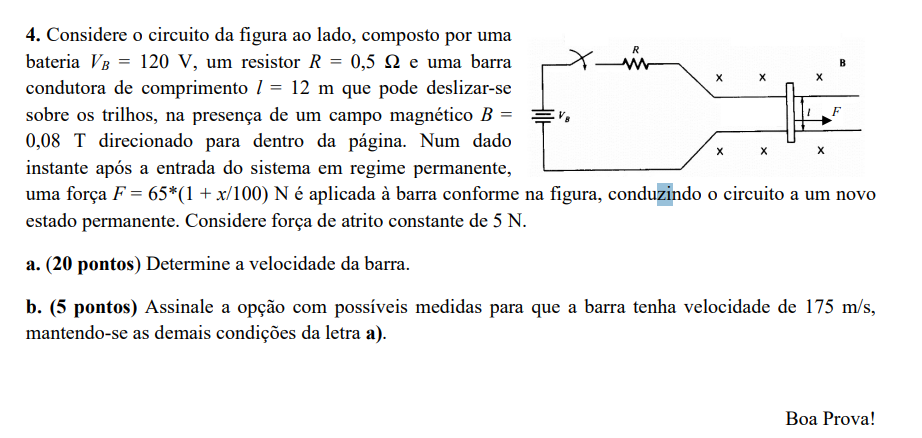

In [18]:
#qUESTAO 4

# Entrada de x
x = int(input("Digite o valor de x (ex: 21): "))
if x == 0:
    x = 100

# Dados
VB = 120        # Volts
R = 0.5         # Ohms
l = 12          # metros
B = 0.08        # Tesla
Fatrito = 5     # Newtons

# Força aplicada
F = 65 * (1 + x / 100)

# Cálculo da velocidade v
numerador = B * l * VB - R * (F - Fatrito)
denominador = (B * l)**2
v = numerador / denominador

print(f"\nResultado Questão 4a:")
print(f"Para x = {x}, a velocidade da barra é: {v:.2f} m/s")


v_desejada = 175  # m/s

R_necessaria = (B * l * VB - v_desejada * (B * l)**2) / (F - Fatrito)

print(f"\nResultado Questão 4b:")
print(f"Para manter as condições da letra (a) e alcançar v = {v_desejada} m/s,")
print(f"a resistência R deve ser ajustada para: {R_necessaria:.4f} Ω")

print("\nOutras possíveis medidas:")
print("- Aumentar a tensão da bateria VB")
print("- Aumentar a força aplicada F")
print("- Reduzir a resistência do circuito R (como calculado acima)")


Digite o valor de x (ex: 21): 100

Resultado Questão 4a:
Para x = 100, a velocidade da barra é: 57.18 m/s

Resultado Questão 4b:
Para manter as condições da letra (a) e alcançar v = 175 m/s,
a resistência R deve ser ajustada para: -0.3686 Ω

Outras possíveis medidas:
- Aumentar a tensão da bateria VB
- Aumentar a força aplicada F
- Reduzir a resistência do circuito R (como calculado acima)
